In [1]:
%matplotlib inline

# It is best to start with USE_GPU = False (implying CPU). Switch USE_GPU to True only if you want to use GPU. However... 
# we strongly recommend to wait until you are absolutely sure your CPU-based code works (at least on single image dataset)
USE_GPU = True

# Python Libraries
import random
import math
import numbers
import platform
import copy
import sys
sys.path.append('..')

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF


from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import importlib
import augmentation_tools
importlib.reload(augmentation_tools)
from augmentation_tools import (showPoly, get_warped_corners_image, get_valid_affine_range,
SSTransformation, square_in_sqare, get_aug_dataset, show_reg_aug_side_by_side,save_im_and_label,
                               show_reg_aug_side_by_side_norm)


In [2]:
# dataset = 'cub2011'
dataset = 'MNIST'
dataset = 'cifar10'


dataset_regular, dataset_aug = get_aug_dataset(
        dataset=dataset, 
        use_train=False, 
        data_root_ovr=None, 
        sstransformation=dict(max_r=45.,
    max_t=30.,
    max_s=1.1,),
        seed=1
    )

Files already downloaded and verified
Files already downloaded and verified


In [3]:
SAVE = False
if SAVE == True:
    save_im_and_label(filepath='../numpy_datasets/{}_augmented'.format(dataset),dataset=dataset_aug)


# The following cell vizualizes the dataset with and without augmentations. Even rows are augmented, while odd rows are clean

In [4]:
def show_reg_aug_side_by_side_norm(dataset_regular,dataset_aug,total_plots=40,
                              plots_per_row=5,figsize=(20,67),savepath=None,
                              cmap='viridis',offset=0):
    """Funtion plots regular and augmented images side by side for comparison."""
    classes = dataset_regular.classes
    n = np.ceil(total_plots/plots_per_row).astype(np.int32) * 2
    fig, axs = plt.subplots(n, plots_per_row, figsize=figsize)
    WIDTH=3
 
    for x in range(total_plots):
        norm = torch.norm(dataset_regular[x+offset][0] - dataset_aug[x+offset][0],p=float('inf'))

        c,r = x % plots_per_row, int(x/plots_per_row) * 2
        
        title = "$\|\mathcal{{I}}-\mathcal{{I}}'\|_\infty = {:.4f}$".format(norm.item())
        
        axs[r,c].set_title(title,fontsize=15)
        axs[r,c].imshow(dataset_regular[x+offset][0].permute(1,2,0),cmap=cmap)
        axs[r,c].set_xticklabels([])
        axs[r,c].set_yticklabels([])
#         axs[r,c].set_ylabel('x')
        axs[r,c].set_aspect('equal')
        axs[r,c].tick_params(bottom=False,top=False,left=False,right=False)
        axs[r,c].set_axis_off()
        for axis in ['top','bottom','left','right']:
            axs[r,c].spines[axis].set_linewidth(WIDTH)
        for spine in axs[r,c].spines.values():
            spine.set_edgecolor('blue')
        
        r += 1
#         title = r"$\|\mathcal{{I}}-\mathcal{{I}}'\|_\infty = "+ repr("{:.4f}$".format(norm.item()))
#         axs[r,c].set_title(title)
        axs[r,c].imshow(dataset_aug[x+offset][0].permute(1,2,0),cmap=cmap)
        axs[r,c].set_xticklabels([])
        axs[r,c].set_yticklabels([])
#         axs[r,c].set_ylabel('x\'')
        axs[r,c].set_aspect('equal')
        axs[r,c].tick_params(bottom=False,top=False,left=False,right=False)
        axs[r,c].set_axis_off()
        for axis in ['top','bottom','left','right']:
            axs[r,c].spines[axis].set_linewidth(WIDTH)
        for spine in axs[r,c].spines.values():
            spine.set_edgecolor('red')

    if savepath:
        fig.savefig(savepath,bbox_inches='tight',dpi=500)
    
    return fig

/home/therien/Documents/github/adaptive_auto_attack/notebooks/../augmentation_tools.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  return ((y-b)/a,y)


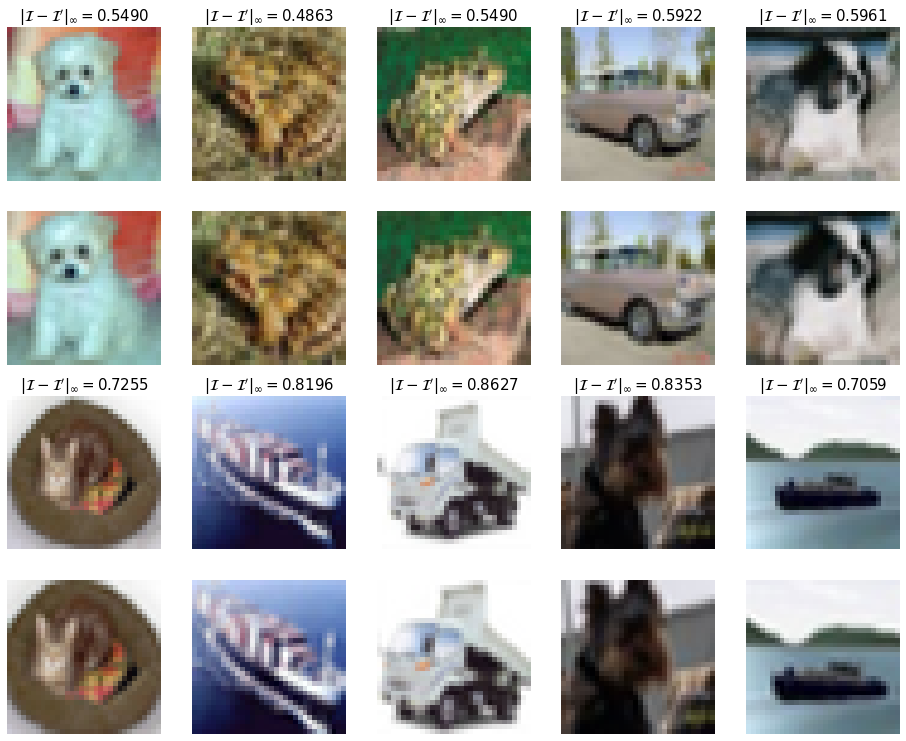

In [5]:
if dataset == 'MNIST':
    cmap = 'gray'
else:
    cmap = None
    
a = show_reg_aug_side_by_side_norm(
    dataset_regular,
    dataset_aug,
    total_plots=10,
    plots_per_row=5,
    figsize=(16,13),
    savepath="images.png",
    cmap=cmap,
    offset=510
)

In [6]:
norms_linf = []
norms_l2 = []
norms_l1 = []
for d1,d2 in zip(dataset_regular,dataset_aug):
    x1,_ = d1
    x2,_ = d2
    norms_linf.append(torch.norm(x1-x2,p=float('inf')).item())
    norms_l2.append(torch.norm(x1-x2,p=2).item())
    norms_l1.append(torch.norm(x1-x2,p=1).item())

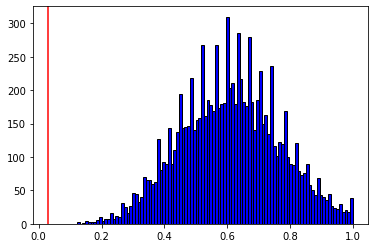

In [7]:

binwidth = 1

plt.hist(norms_linf, bins = 100,
         color = 'blue', edgecolor = 'black')
plt.axvline(x=0.031,color='red')
plt.show()

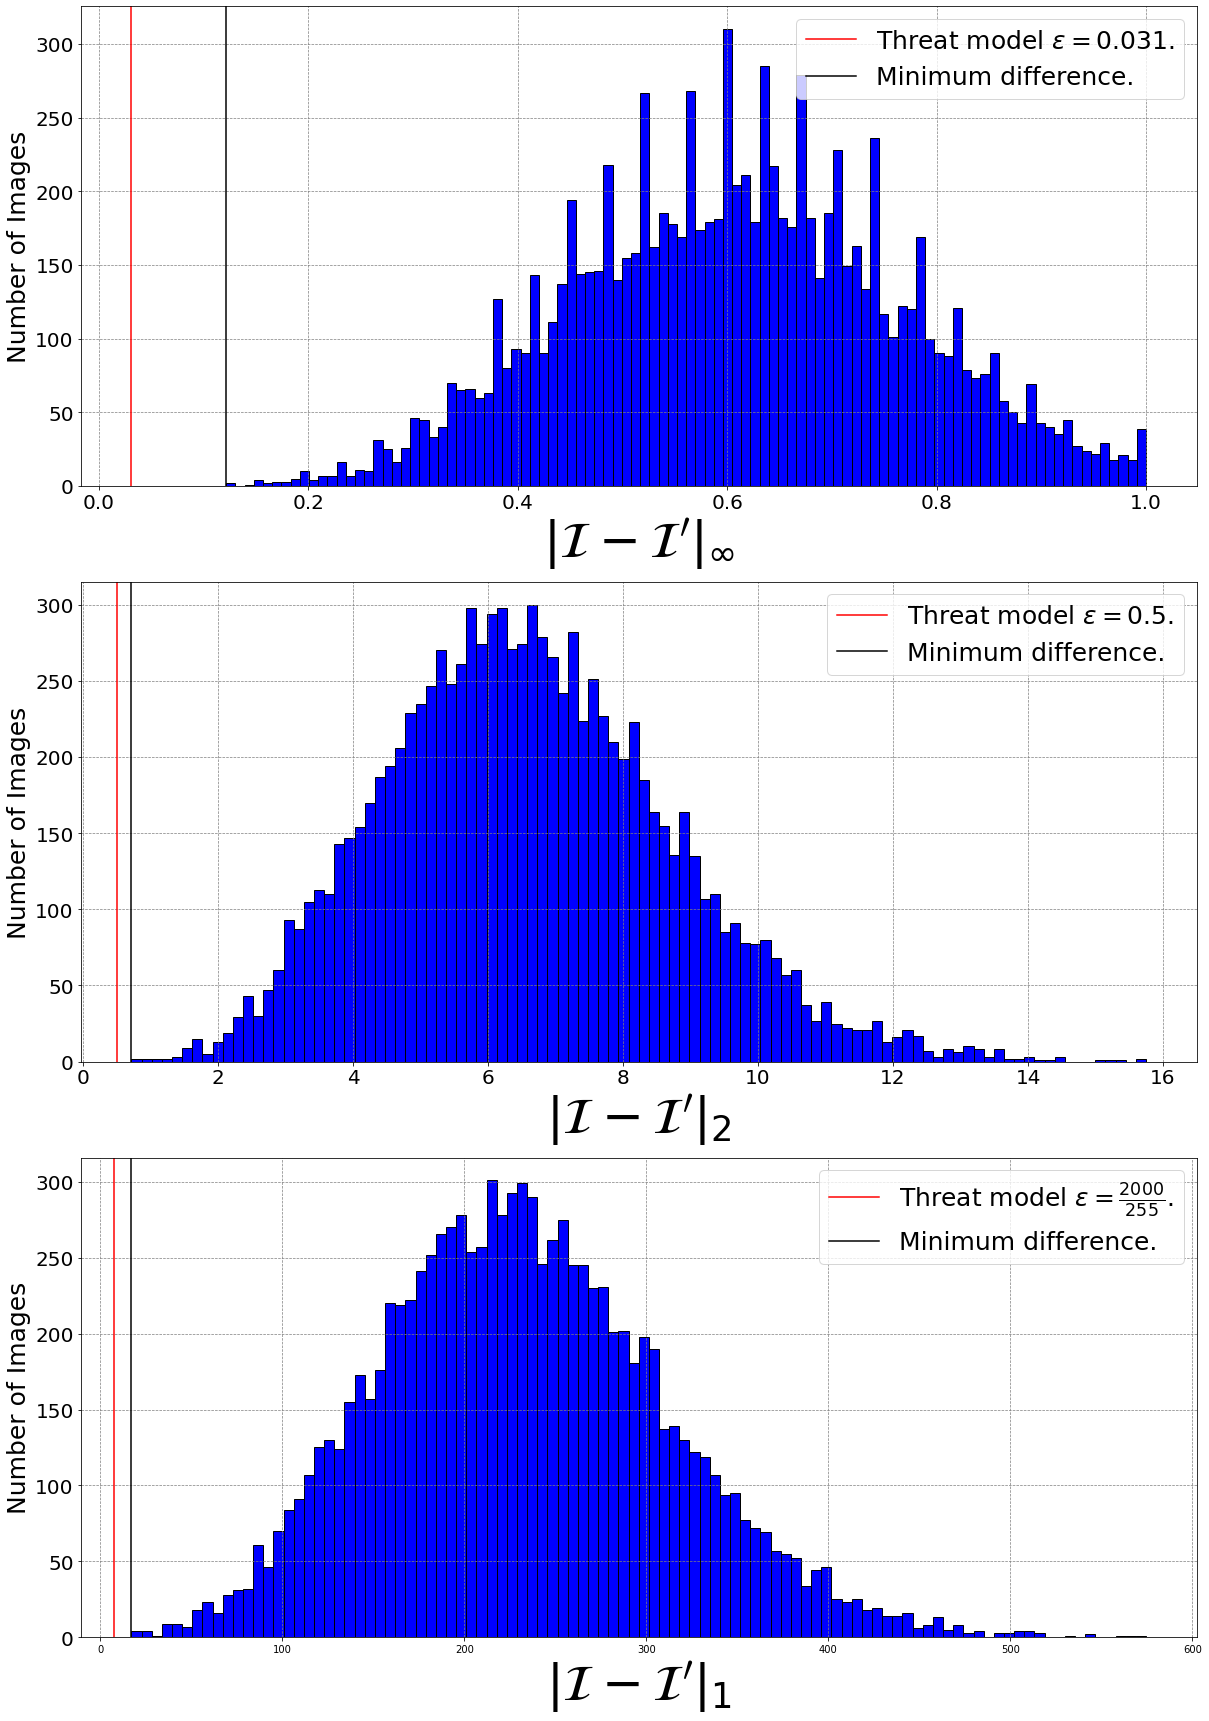

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(2*10,2*15))
legend_fontsize = 25
xlab_fontsize = 50
ylab_fontsize = 25
xtick_fontsize =20
idx = 0
axs[idx].hist(norms_linf, bins = 100, color = 'blue', edgecolor = 'black')#, label='Distance frequency.')
axs[idx].axvline(x=0.031,color='red',label='Threat model $\epsilon=0.031$.')
axs[idx].axvline(x=np.min(norms_linf),color='black',label='Minimum difference.')
axs[idx].set_xlabel(r"$\|\mathcal{I}-\mathcal{I}'\|_\infty$",fontsize=xlab_fontsize)
axs[idx].set_ylabel("Number of Images",fontsize=ylab_fontsize)
axs[idx].legend(fontsize=legend_fontsize)
axs[idx].tick_params(axis='x', labelsize=xtick_fontsize)
axs[idx].tick_params(axis='y', labelsize=xtick_fontsize)
axs[idx].grid(color='gray', linestyle='--', linewidth=0.7,zorder=100)

idx=1
axs[idx].hist(norms_l2, bins = 100, color = 'blue', edgecolor = 'black')#, label='Distance frequency.')
l2_threat_model = 0.5
axs[idx].axvline(x=l2_threat_model,color='red',label='Threat model $\epsilon={}$.'.format(l2_threat_model))
axs[idx].axvline(x=np.min(norms_l2),color='black',label='Minimum difference.')
axs[idx].set_xlabel("$\|\mathcal{I}-\mathcal{I}'\|_2$",fontsize=xlab_fontsize)
axs[idx].set_ylabel("Number of Images",fontsize=ylab_fontsize)
axs[idx].legend(fontsize=legend_fontsize)
axs[idx].tick_params(axis='x', labelsize=xtick_fontsize)
axs[idx].tick_params(axis='y', labelsize=xtick_fontsize)
axs[idx].grid(color='gray', linestyle='--', linewidth=0.7,zorder=100)

idx=2
axs[idx].hist(norms_l1, bins = 100, color = 'blue', edgecolor = 'black')#, label='Distance frequency.')
l1_threat_model = 2000/255
axs[idx].axvline(x=l1_threat_model,color='red',label=r'Threat model $\epsilon=\frac{2000}{255}$.')
axs[idx].axvline(x=np.min(norms_l1),color='black',label='Minimum difference.')
axs[idx].set_xlabel(r"$\|\mathcal{I}-\mathcal{I}'\|_1$",fontsize=xlab_fontsize)
axs[idx].set_ylabel("Number of Images",fontsize=ylab_fontsize)
axs[idx].legend(fontsize=legend_fontsize)
axs[idx].tick_params(axis='x', labelsize=xtick_fontsize)
axs[idx].tick_params(axis='y', labelsize=xtick_fontsize)
axs[idx].grid(color='gray', linestyle='--', linewidth=0.7,zorder=100)


# axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=5)
# fig.title("CIFAR10 Freqency Histograms")
plt.xticks(fontsize=10)


plt.savefig('cifar10_norm_histogram.png',bbox_inches='tight',dpi=500)

plt.show()


In [13]:
aaa_compose_rt = np.load('AAA_compose_RT.npy')
rt_ims = np.load('RT.npy')

In [19]:
aaa_compose_rt.shape
# dataset_regular[0][0].shape

(10000, 3, 32, 32)

In [29]:
np.moveaxis(aaa_compose_rt[0,...],0,2).shape

(32, 32, 3)

In [27]:
aaa_compose_rt[0,...].shape

(3, 32, 32)

In [53]:
preds = np.load("is_classified_correctly.npy")

In [71]:
def show_reg_aug_side_by_side_adv_adv(dataset_regular,dataset_aug,preds,classes,total_plots=40,
                              plots_per_row=5,figsize=(20,67),savepath=None,
                              cmap='viridis',offset=0):
    """Funtion plots regular and augmented images side by side for comparison."""
    n = np.ceil(total_plots/plots_per_row).astype(np.int32) * 3
    fig, axs = plt.subplots(n, plots_per_row, figsize=figsize)
    
    
 
    for x in range(total_plots):
        norm = np.linalg.norm((dataset_regular[x+offset,...] - dataset_aug[x+offset,...]).flatten(),ord=np.inf)
        while(norm == 0. or preds[x+offset]):
            offset+=1
            norm = np.linalg.norm((dataset_regular[x+offset,...] - dataset_aug[x+offset,...]).flatten(),ord=np.inf)
#         norm=0
        title = "$\|\mathcal{{I}}-\mathcal{{I}}'\|_\infty = {:.4f}$".format(norm)
        c,r = x % plots_per_row, int(x/plots_per_row) * 3
        
        axs[r,c].imshow(classes[x+offset][0].permute(1,2,0),cmap=cmap)
        axs[r,c].set_axis_off()
        
        r+=1
        
        
#         axs[r,c].set_title(title)#"RT Norm: {:.4f}, is ROB: {}".format(norm,preds[x+offset]))#.item()))
        axs[r,c].imshow(np.moveaxis(dataset_aug[x+offset,...],0,2),cmap=cmap)
        axs[r,c].set_axis_off()
        
        r += 1
#         axs[r,c].set_title("AAA comp RT Norm: {:.4f}".format(norm))#.item()))
        axs[r,c].imshow(np.moveaxis(dataset_aug[x+offset,...],0,2),cmap=cmap)
        axs[r,c].set_axis_off()

    if savepath:
        fig.savefig(savepath,bbox_inches='tight',dpi=500)
    
    return fig

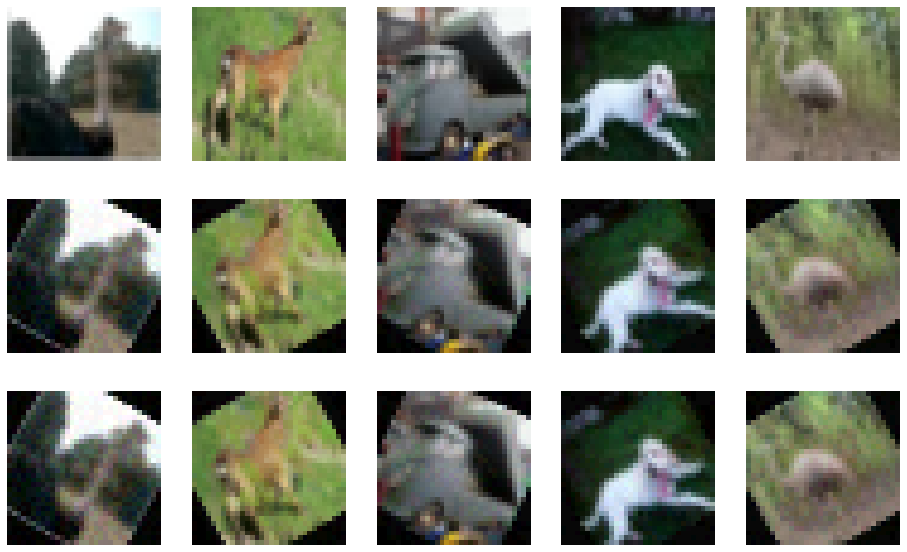

In [85]:
if dataset == 'MNIST':
    cmap = 'gray'
else:
    cmap = None
    
a = show_reg_aug_side_by_side_adv_adv(
    rt_ims,
    aaa_compose_rt,
    preds,
    classes=dataset_regular,
    total_plots=5,
    plots_per_row=5,
    figsize=(16,10),
    cmap=cmap,
    savepath='aaa_comp_rt_and_rt.png',
    offset=6900
)

In [30]:
def show_reg_aug_side_by_side_adv(dataset_regular,dataset_aug,total_plots=40,
                              plots_per_row=5,figsize=(20,67),savepath=None,
                              cmap='viridis',offset=0):
    """Funtion plots regular and augmented images side by side for comparison."""
    classes = dataset_regular.classes
    n = np.ceil(total_plots/plots_per_row).astype(np.int32) * 2
    fig, axs = plt.subplots(n, plots_per_row, figsize=figsize)
 
    for x in range(total_plots):
        norm = torch.norm(dataset_regular[x+offset][0] - dataset_aug[x+offset][0],p=float('inf'))

        c,r = x % plots_per_row, int(x/plots_per_row) * 2
        axs[r,c].set_title("Nat. {} Norm: {:.4f}".format(classes[dataset_regular[x+offset][1]],norm.item()))
        axs[r,c].imshow(dataset_regular[x+offset][0].permute(1,2,0),cmap=cmap)
        axs[r,c].set_axis_off()
        
        r += 1
        axs[r,c].set_title("Aug. {} Norm: {:.4f}".format(classes[dataset_regular[x+offset][1]],norm.item()))
        axs[r,c].imshow(np.moveaxis(dataset_aug[x+offset,...],0,2),cmap=cmap)
        axs[r,c].set_axis_off()

    if savepath:
        fig.savefig(savepath,bbox_inches='tight',dpi=500)
    
    return fig

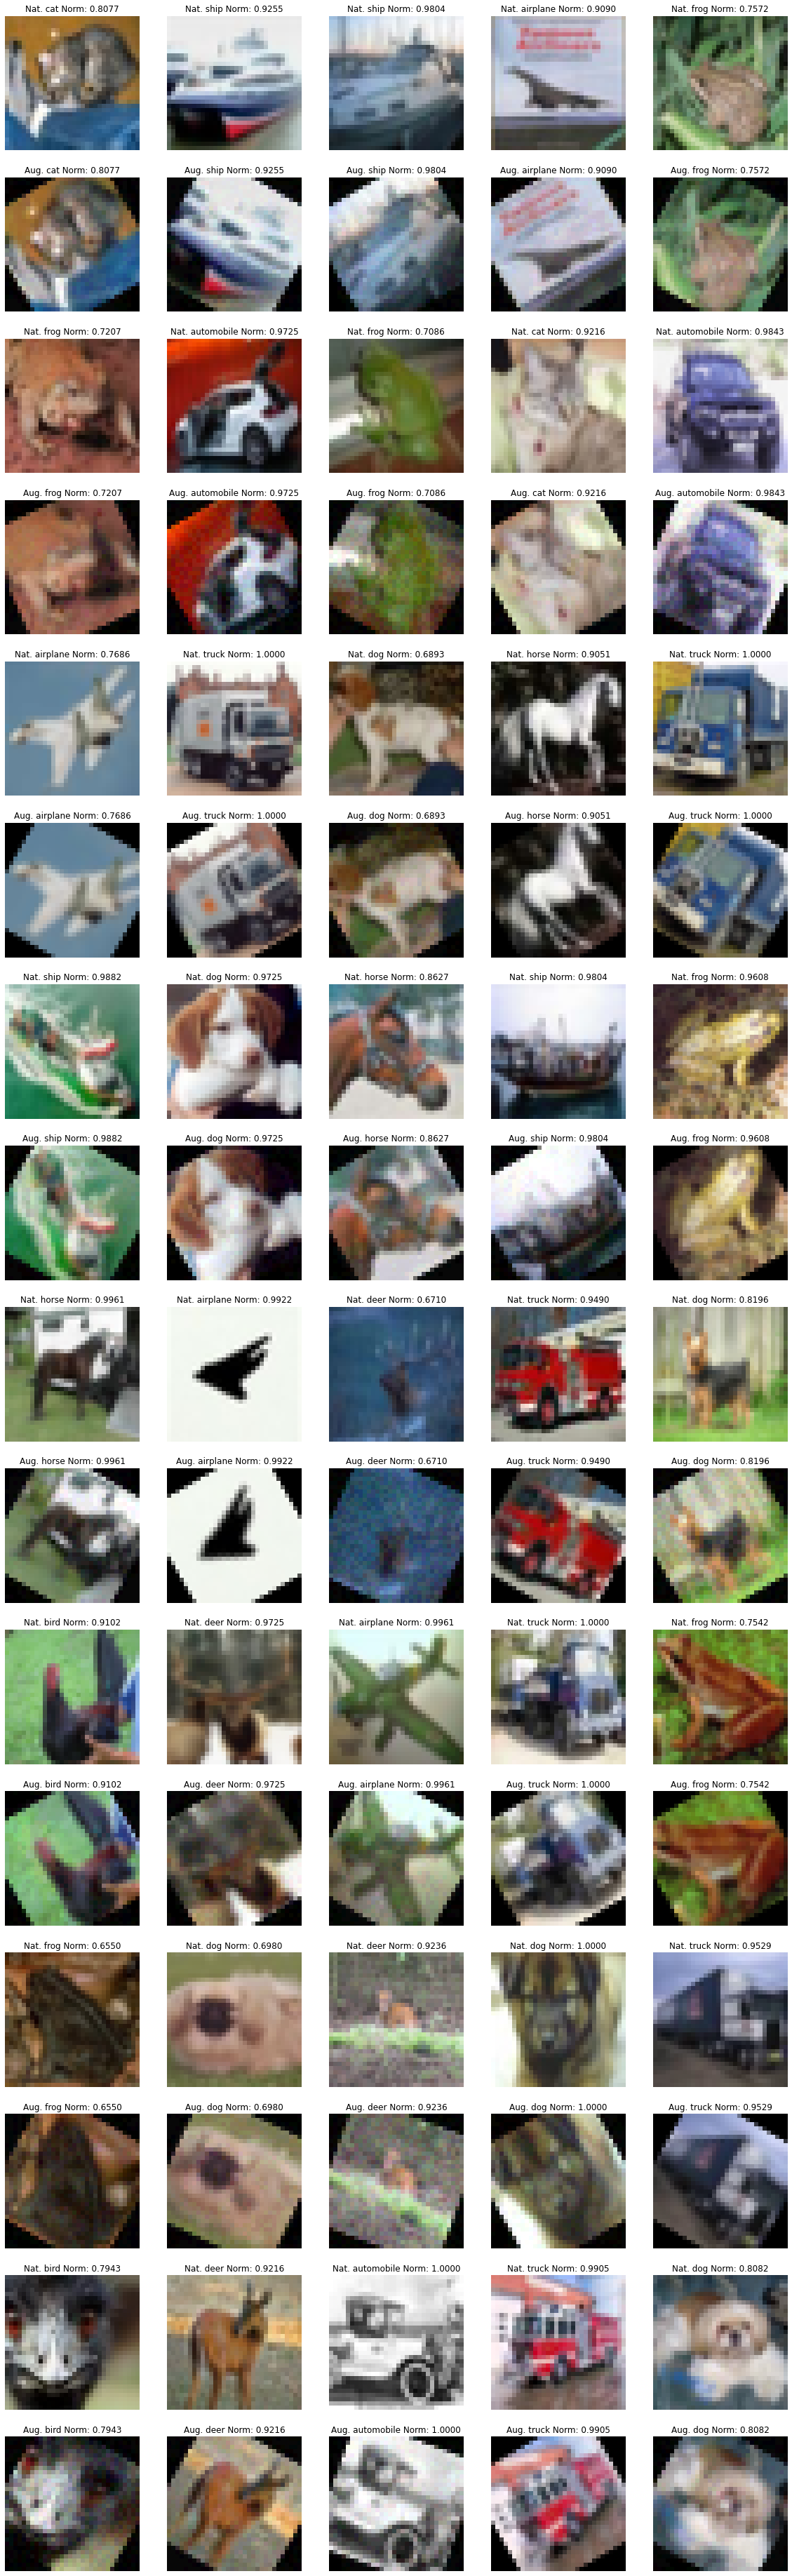

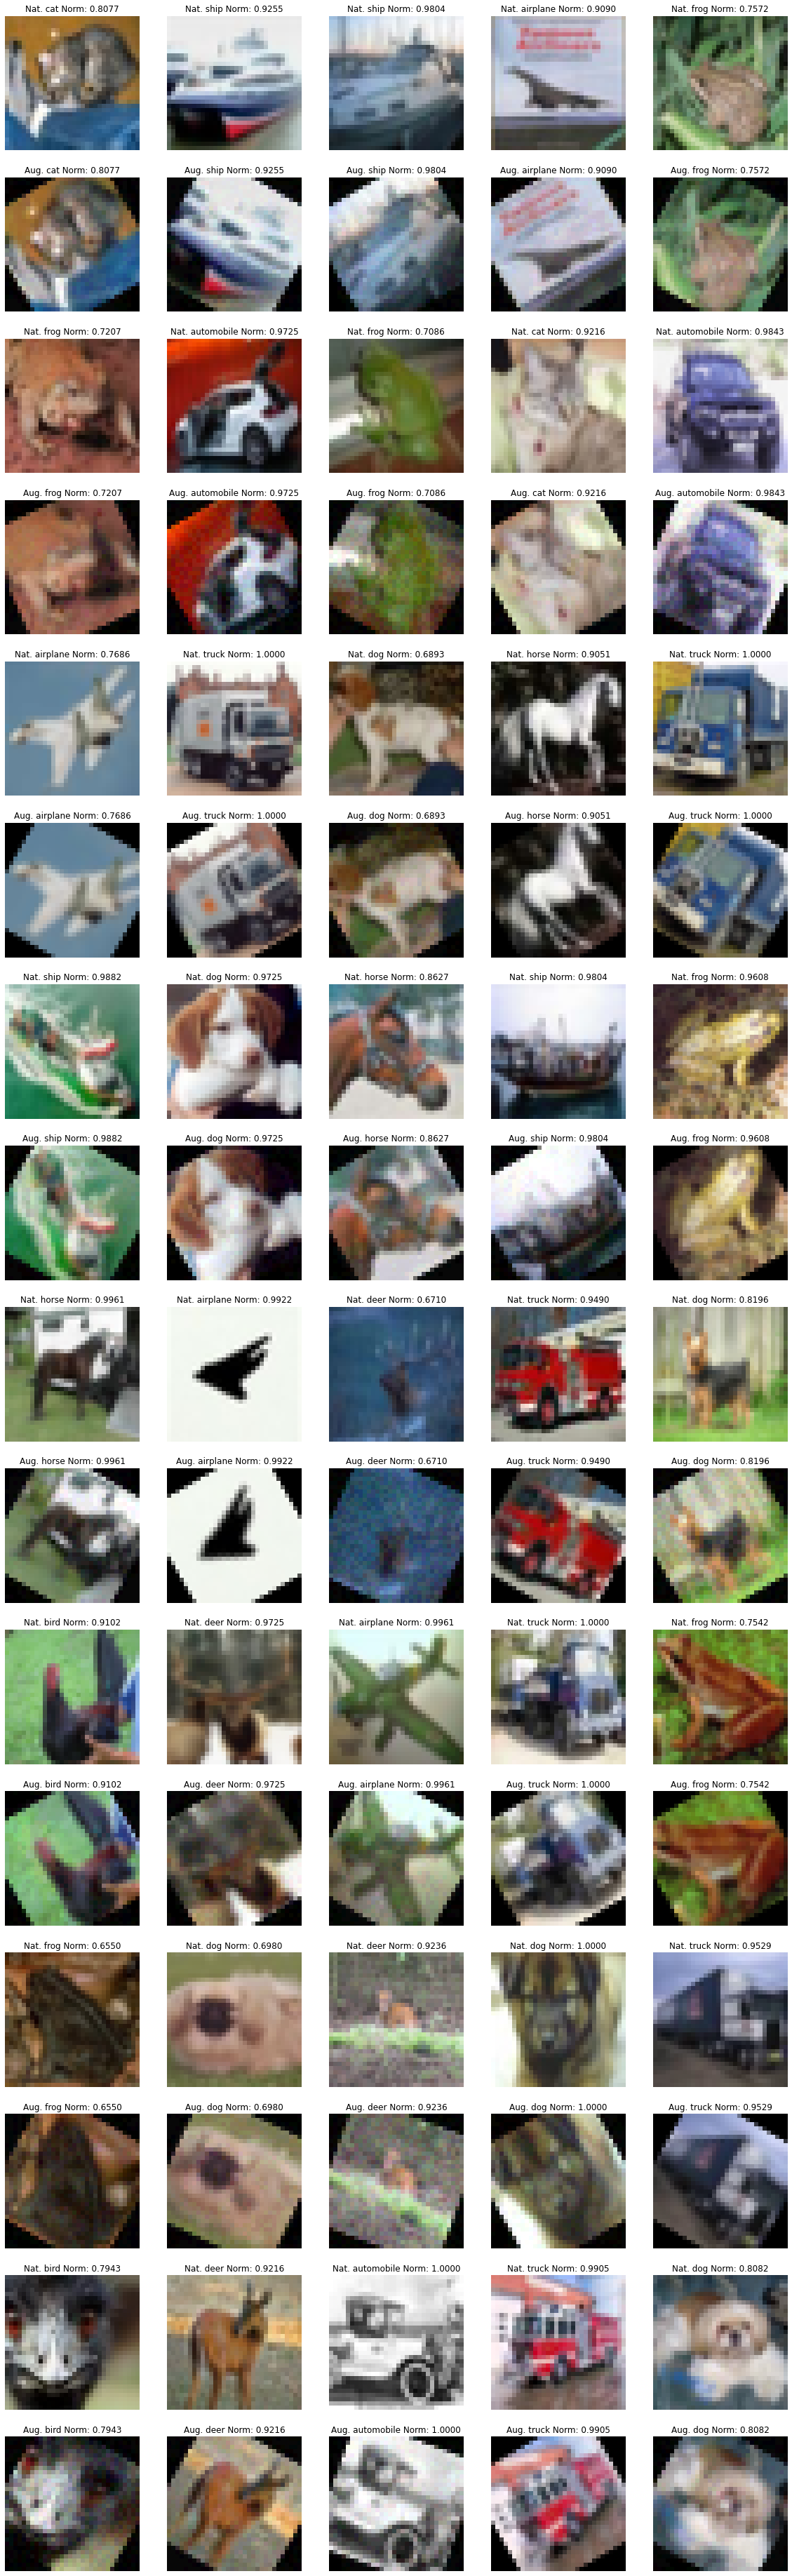

In [31]:
if dataset == 'MNIST':
    cmap = 'gray'
else:
    cmap = None
    
show_reg_aug_side_by_side_adv(
    dataset_regular,
    aaa_compose_rt,
    total_plots=40,
    plots_per_row=5,
    figsize=(20,67),
    savepath=None,
    cmap=cmap
)

In [88]:
def show_reg_aug_side_by_side_norm(dataset_regular,dataset_aug,total_plots=40,
                              plots_per_row=5,figsize=(20,67),savepath=None,
                              cmap='viridis',offset=0):
    """Funtion plots regular and augmented images side by side for comparison."""
    classes = dataset_regular.classes
    n = np.ceil(total_plots/plots_per_row).astype(np.int32) * 2
    fig, axs = plt.subplots(n, plots_per_row, figsize=figsize)
 
    for x in range(total_plots):
        norm = torch.norm(dataset_regular[x+offset][0] - dataset_aug[x+offset][0],p=float('inf'))

        c,r = x % plots_per_row, int(x/plots_per_row) * 2
        axs[r,c].set_title("Nat. {} Norm: {:.4f} {}".format(classes[dataset_regular[x+offset][1]],norm.item(),x+offset))
        axs[r,c].imshow(dataset_regular[x+offset][0].permute(1,2,0),cmap=cmap)
        axs[r,c].set_axis_off()
        
        r += 1
        axs[r,c].set_title("Aug. {} Norm: {:.4f}  {}".format(classes[dataset_aug[x+offset][1]],norm.item(),x+offset))
        axs[r,c].imshow(dataset_aug[x+offset][0].permute(1,2,0),cmap=cmap)
        axs[r,c].set_axis_off()

    if savepath:
        fig.savefig(savepath,bbox_inches='tight',dpi=500)
    
    return fig

In [89]:
dataset = 'MNIST'
# dataset = 'cifar10'


dataset_regular, dataset_aug = get_aug_dataset(
        dataset=dataset, 
        use_train=False, 
        data_root_ovr=None, 
        sstransformation=dict(max_r=45.,
    max_t=30.,
    max_s=1.1,),
        seed=1
    )

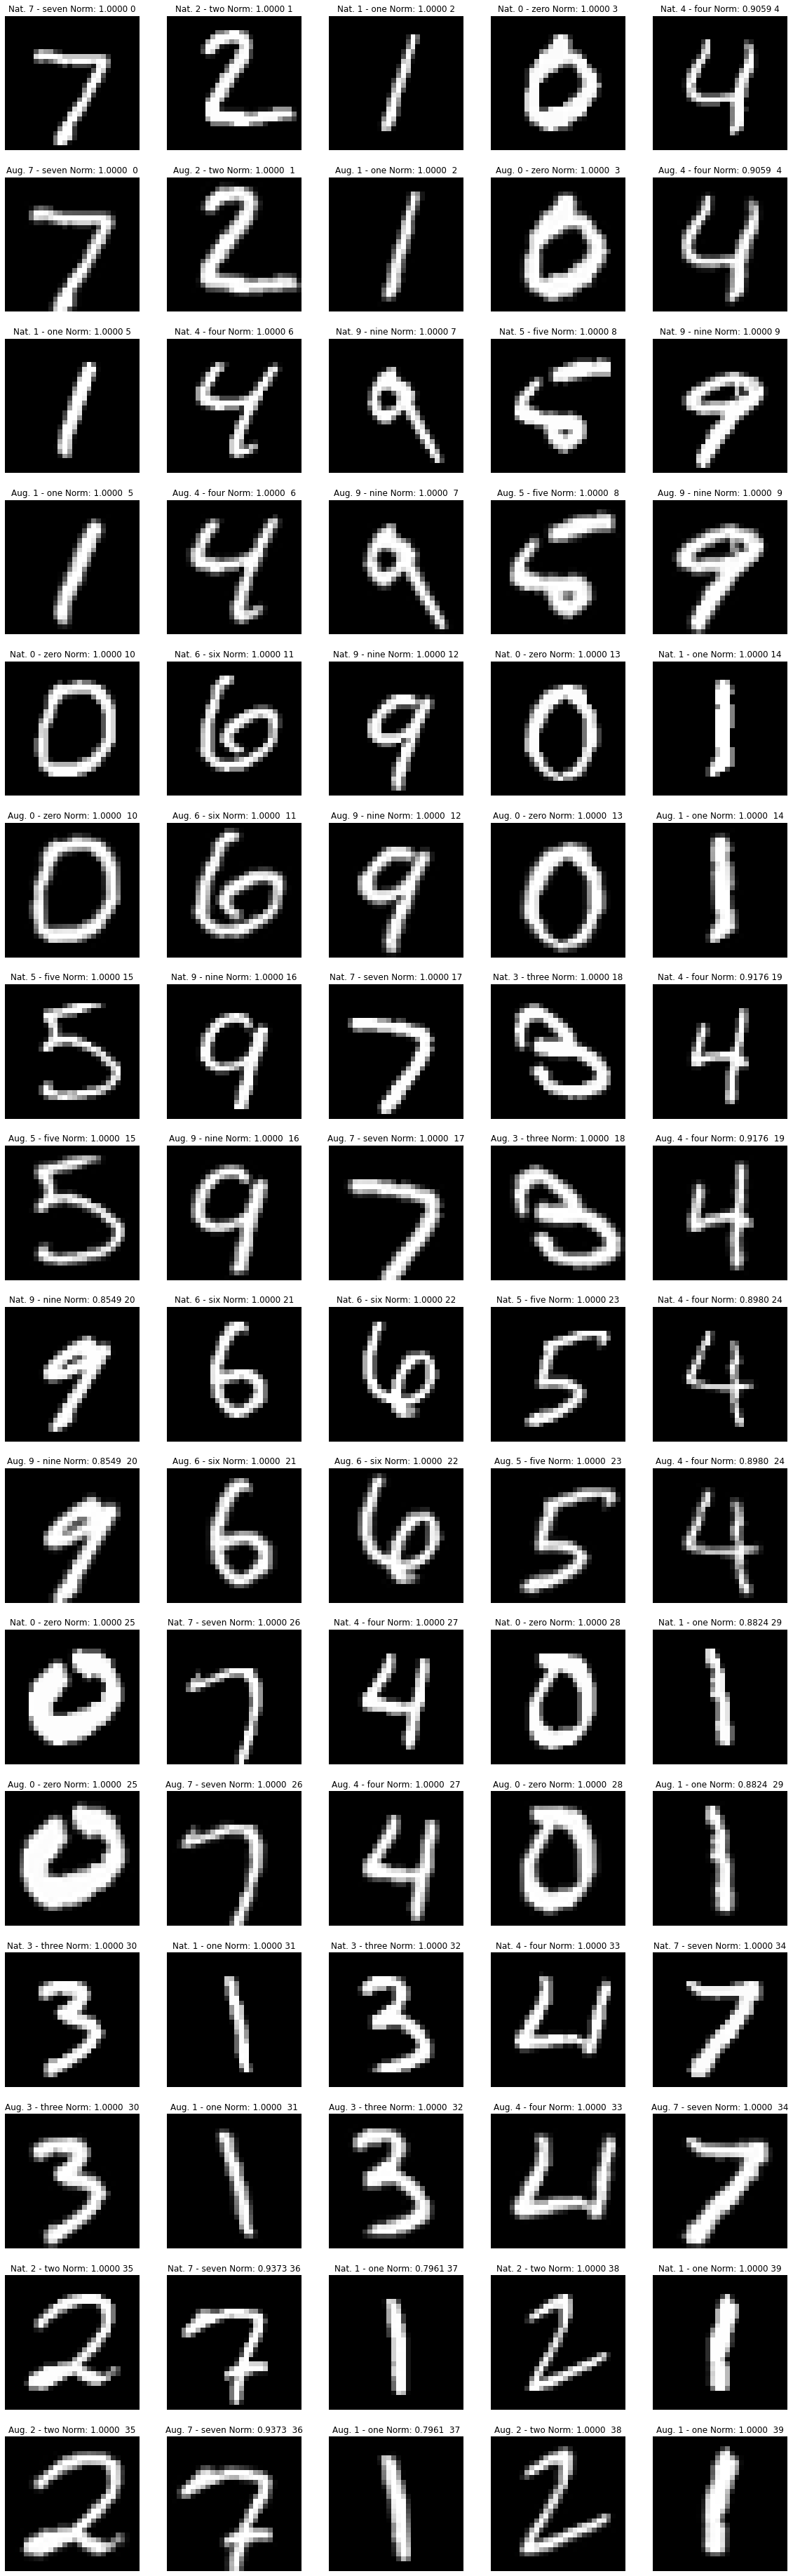

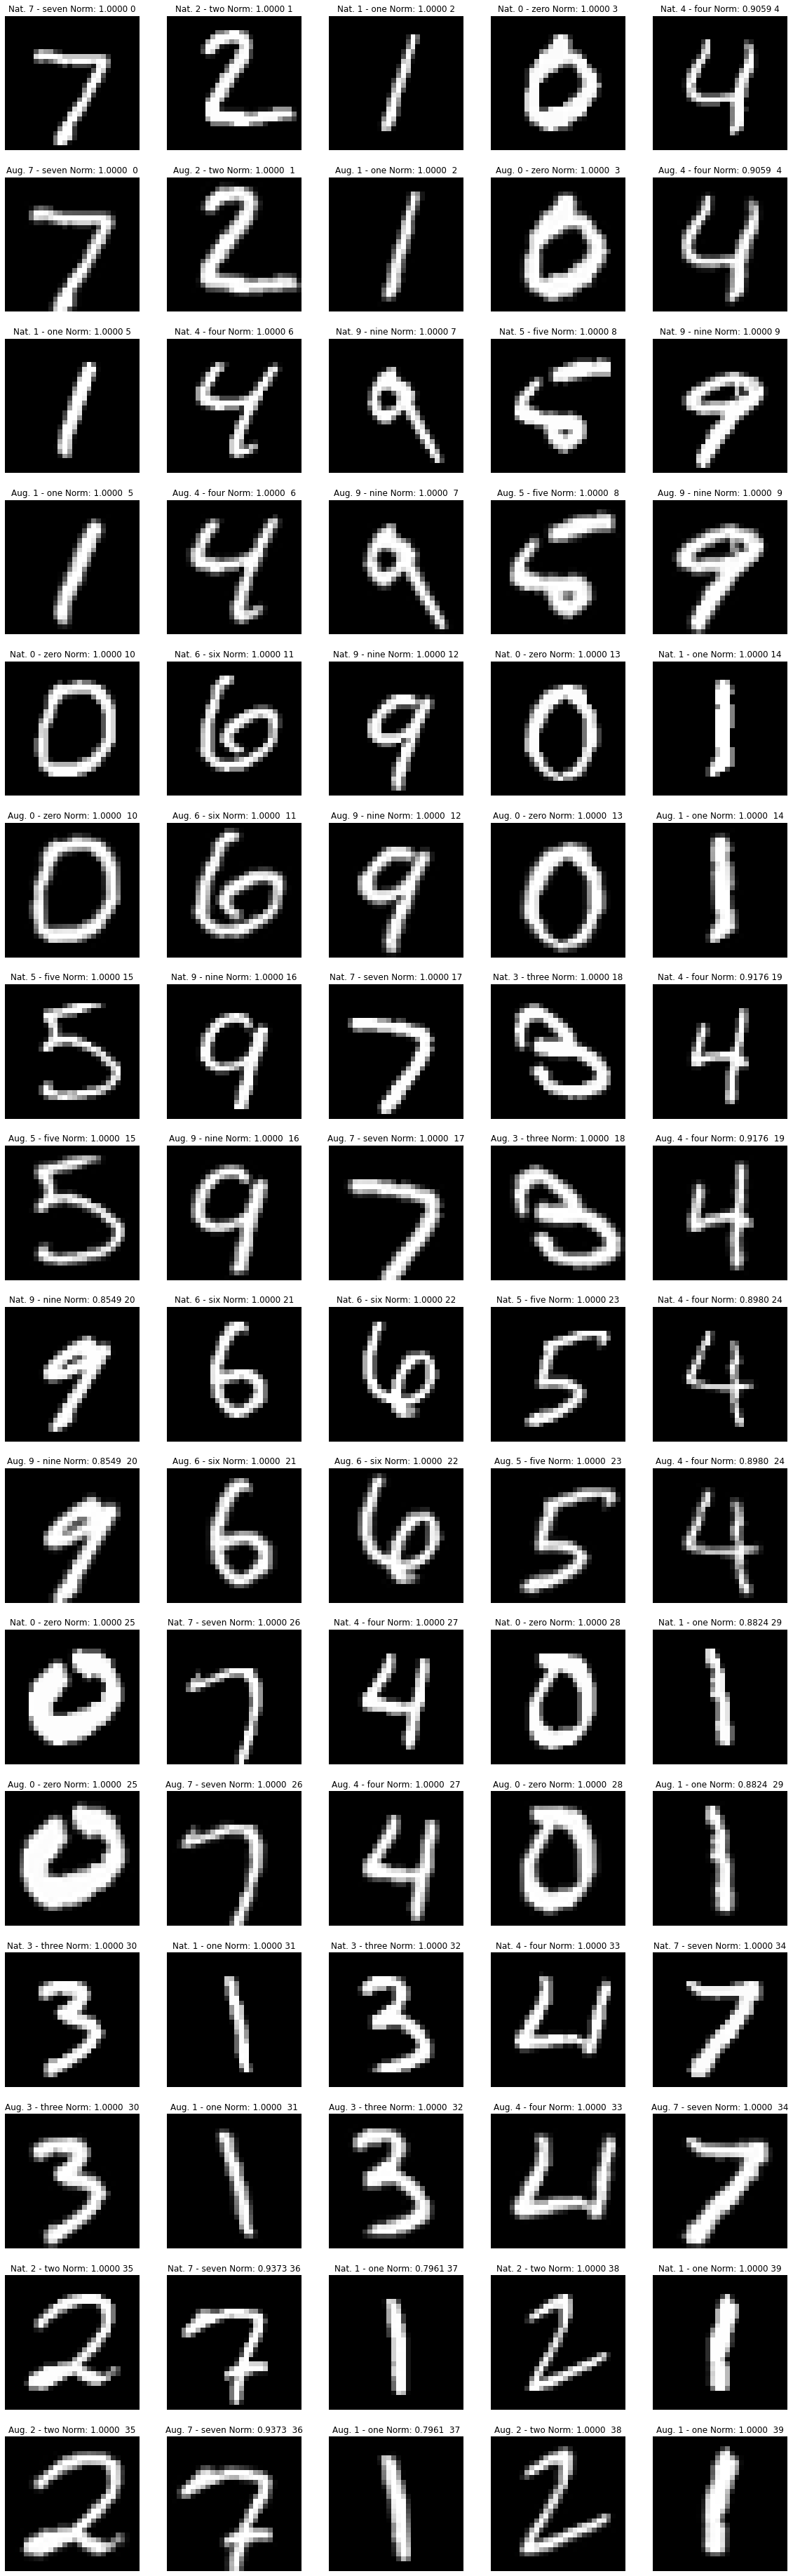

In [91]:
dataset = 'MNIST'

if dataset == 'MNIST':
    cmap = 'gray'
else:
    cmap = None
    
show_reg_aug_side_by_side_norm(
    dataset_regular,
    dataset_aug,
    total_plots=40,
    plots_per_row=5,
    figsize=(20,67),
    savepath='luke_ones.png',
    cmap=cmap
)

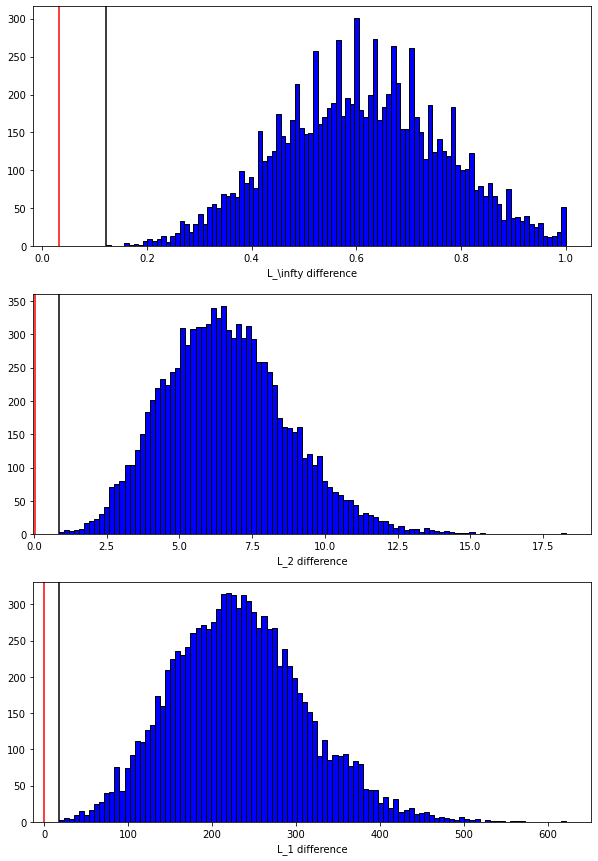

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(10,15))
axs[0].hist(norms_linf, bins = 100, color = 'blue', edgecolor = 'black')
axs[0].axvline(x=0.031,color='red')
axs[0].axvline(x=np.min(norms_linf),color='black')
axs[0].set_xlabel("L_\infty difference")
axs[1].hist(norms_l2, bins = 100, color = 'blue', edgecolor = 'black')
axs[1].axvline(x=0.031,color='red')
axs[1].axvline(x=np.min(norms_l2),color='black')
axs[1].set_xlabel("L_2 difference")
axs[2].hist(norms_l1, bins = 100, color = 'blue', edgecolor = 'black')
axs[2].axvline(x=0.031,color='red')
axs[2].axvline(x=np.min(norms_l1),color='black')
axs[2].set_xlabel("L_1 difference")
# fig.title("CIFAR10 Freqency Histograms")
plt.show()

ValueError: keyword fontsize is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

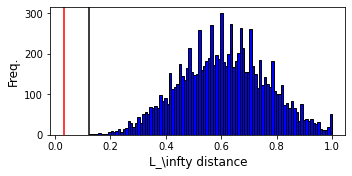

In [83]:
# matplotlib.rc('font',family='TeX Gyre Heros')
fig3 = plt.figure(figsize=(18,8))
gs = fig3.add_gridspec(3,6,wspace=0.5, hspace=0.2)
ylab_font_size = "large"
xlab_font_size = "large"
f3_linf = fig3.add_subplot(gs[0,3:5],xlabel="Epoch",ylabel="Filterbank Distance")
f3_linf.set_ylabel("Freq.", fontsize=ylab_font_size)
f3_linf.set_xlabel("L_\infty distance",fontsize=xlab_font_size)
f3_linf.hist(norms_linf, bins = 100, color = 'blue', edgecolor = 'black')
f3_linf.axvline(x=0.031,color='red')
f3_linf.axvline(x=np.min(norms_linf),color='black')
f3_linf.tick_params(fontsize=1)


f3_l2 = fig3.add_subplot(gs[1,3:5],xlabel="Epoch",ylabel="Filterbank Distance")#,left=20)
f3_l2.set_ylabel("Freq.", fontsize=ylab_font_size)
f3_l2.set_xlabel("L_2 distance",fontsize=xlab_font_size)
f3_l2.hist(norms_l2, bins = 100, color = 'blue', edgecolor = 'black')
f3_l2.axvline(x=0.031,color='red')
f3_l2.axvline(x=np.min(norms_l2),color='black')


f3_l1 = fig3.add_subplot(gs[2,3:5],xlabel="Epoch",ylabel="Filterbank Distance")
f3_l1.set_ylabel("Freq.", fontsize=ylab_font_size)
f3_l1.set_xlabel("L_1 distance",fontsize=xlab_font_size)
f3_l1.hist(norms_l1, bins = 100, color = 'blue', edgecolor = 'black')
f3_l1.axvline(x=0.031,color='red')
f3_l1.axvline(x=np.min(norms_l1),color='black')


nat_im1 = fig3.add_subplot(gs[0,0])
trans_im1 = fig3.add_subplot(gs[1,0])
lp_im1 = fig3.add_subplot(gs[2,0])

nat_im2 = fig3.add_subplot(gs[0,1])
trans_im2 = fig3.add_subplot(gs[1,1])
lp_im2 = fig3.add_subplot(gs[2,1])

nat_im3 = fig3.add_subplot(gs[0,2])
trans_im3 = fig3.add_subplot(gs[1,2])
lp_im3 = fig3.add_subplot(gs[2,2])

for ax,dataset,idx,ds_name in [(nat_im1,dataset_regular,0,'Nat.'),(trans_im1,dataset_aug,0,'Aug.'),
                               (lp_im1,dataset_aug,0,'Aug.'),(nat_im2,dataset_regular,1,'Nat.'),
                               (trans_im2,dataset_aug,1,'Aug.'),(lp_im2,dataset_aug,1,'Aug.'),
                               (nat_im3,dataset_regular,2,'Nat.'),(trans_im3,dataset_aug,2,'Aug.'),
                               (lp_im3,dataset_aug,2,'Aug.')]:
    ax.imshow(dataset[idx][0].permute(1,2,0))
    ax.set_axis_off()
    ax.set_title("{} {} Norm: {:.4f}".format(ds_name,dataset.classes[dataset[idx][1]],norms_linf[idx]))



In [ ]:
# matplotlib.rc('font',family='TeX Gyre Heros')
fig3 = plt.figure(figsize=(18,12))
gs = fig3.add_gridspec(4,6,wspace=0.5, hspace=0.25)


f3_ax1 = fig3.add_subplot(gs[0:2,4:6],xlabel="Epoch",ylabel="Filterbank Distance")#0:2,4:6
f3_ax1.set_ylabel("Filterbank Distance", fontsize='x-large')
f3_ax1.set_xlabel("Epoch",fontsize='x-large')
WIDTH = 7
epochs = [x for x in range(len(filterDists['cifar']))]

f3_ax1.plot(epochs, filterDists['kth'], label="KTH-TIPS2", color="#FDCA40", linewidth=2)
f3_ax1.plot(epochs, filterDists['xray'], label="COVIDx-CRX2", color="#DF2935", linewidth=2) 
f3_ax1.plot(epochs, filterDists['cifar'], label="CIFAR-10", color="#3772FF", linewidth=2) 
f3_ax1.plot(epochs, [0 for x in range(len(epochs))], label="tight-frame", color="#080708", linewidth=2)  
#E6E8E6
f3_ax1.legend(fontsize='x-large',bbox_to_anchor=(0.5, 0., 0.5, 0.4)) 


colors = ["#FDCA40","#DF2935","#3772FF","#080708"]
colors = {"tf2":"#080708","tf4":"#080708","kth":"#FDCA40","xray":"#DF2935","cifar":"#3772FF"}

lwptf2 = lwp(S2,filters['tf2'])
lwpcifar2 = lwp(S2,filters['cifar'])
lwptf4 = lwp(S4,filters['tf4'])
lwpxray4 = lwp(S4,filters['xray'])
lwpkth4 = lwp(S4,filters['kth'])

f4_ax_tf2 = fig3.add_subplot(gs[0:2,0:2])#0:2,0:2
f4_ax_tf4 = fig3.add_subplot(gs[2:4,0:2])#2:4,0:2
f4_ax_cifar2 = fig3.add_subplot(gs[0:2,2:4])
f4_ax_xray4 = fig3.add_subplot(gs[2:4,2:4])
f4_ax_kth4 = fig3.add_subplot(gs[2:4,4:6])#2:4,4:6

for g,ax,k,J in [(lwptf2,f4_ax_tf2,'tf2',2),(lwpcifar2,f4_ax_cifar2,'cifar',2),(lwptf4,f4_ax_tf4,'tf4',4),(lwpxray4,f4_ax_xray4,'xray',4),(lwpkth4,f4_ax_kth4,'kth',4)]:
  ax.imshow(g)
  # ax.axis('off')#xmargin=10,ymargin=1)#'off')
  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(WIDTH)
  # ax.axes.set_box_aspect(2)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  ax.tick_params(bottom=False,top=False,left=False,right=False)#,color='green', labelcolor='green',)
  for spine in ax.spines.values():
      spine.set_edgecolor(colors[k])

  if J==2:
    params = [torch.tensor([float(x) for x in y],dtype=torch.float32) for y in filters[k]]
    S2.params_filters = params
    gabors2 = morlets2(S2.grid, S2.params_filters[0], 
                                        S2.params_filters[1], S2.params_filters[2], 
                                        S2.params_filters[3], return_gabors=True).cpu().detach().numpy()
    grid = S2.grid + 20
    for i in np.abs(gabors2) ** 2:
      wave = np.fft.fftshift(i.T)
      ax.contour(grid[0], grid[1], wave, 1, colors='white',linewidths=0.5)
  else:
    # print(J)
    params = [torch.tensor([float(x) for x in y],dtype=torch.float32) for y in filters[k]]
    S4.params_filters = params
    gabors4 = morlets2(S4.grid, S4.params_filters[0], 
                                        S4.params_filters[1], S4.params_filters[2], 
                                        S4.params_filters[3], return_gabors=True).cpu().detach().numpy()
    grid = S4.grid + 32
    for i in np.abs(gabors4) ** 2:
      wave = np.fft.fftshift(i.T)
      # print(wave.shape)
      ax.contour(grid[0], grid[1], wave, 1, colors='white',linewidths=0.5)






fig3.savefig("graph_lwp_w{}_2-3.pdf".format(WIDTH),bbox_inches='tight')

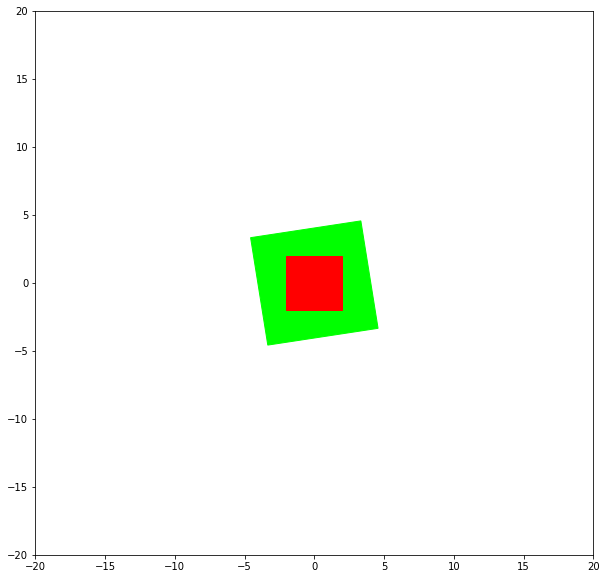

In [5]:
showPoly(outCorners=np.array([[-4.5691323,  3.3351207],[3.3351207,  4.5691323],
                                                       [4.5691323, -3.3351207],[-3.3351207, -4.5691323]]), 
                           inCorners=np.array([[ 2., -2.],[ 2.,  2.],[-2.,  2.],[-2., -2.]]))
    
#     outCorners=np.array([[23.765, 66.235],[66.235, 66.235],[66.235, 23.765],[23.765, 23.765]]), 
#          inCorners=np.array([[-15.5,  15.5],[ 15.5,  15.5],[ 15.5, -15.5],[-15.5, -15.5]]))
 
is_in = square_in_sqare(
    outCorners=np.array([[23.765, 66.235],[66.235, 66.235],[66.235, 23.765],[23.765, 23.765]]), 
    inCorners=np.array([[-15.5,  15.5],[ 15.5,  15.5],[ 15.5, -15.5],[-15.5, -15.5]])
)

assert is_in == False

In [6]:
from skimage.transform import SimilarityTransform
im = np.random.randn(32,32,3)
scale = 1.2248
scaled = get_warped_corners_image(im, SimilarityTransform(scale=scale))

valid_r = get_valid_affine_range(
    warped_corners=scaled['warpedcorners'],orig_corners=scaled['corners'],
    max_=45, affine_type='rotation',threshold=0.001
)
print(valid_r)

15.003890991210938
